In [181]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
from typing import Union, Any
import base64
from numpy.random import permutation
import os
import glob
import PIL
import io
from pprint import pprint

from typing import List, Set
from pydantic import BaseModel, Field

from llama_index.core import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser

import anthropic
from datasets import load_dataset


In [183]:
def image_to_base64(image: Union[str, Any]):

    if isinstance(image, str):
        with open(image, "rb") as image_file:
            binary_data = image_file.read()
        
    else:
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=100)
        image_data.seek(0)
        binary_data = image_data.getvalue()
    
    
    base_64_encoded_data = base64.b64encode(binary_data)
    return base_64_encoded_data.decode('utf-8')

In [184]:
claude = anthropic.Anthropic()

In [185]:
ds = load_dataset("futurehouse/lab-bench", "FigQA")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'ideal', 'distractors', 'canary', 'subtask', 'figure', 'figure-path'],
        num_rows: 181
    })
})

In [186]:
def get_randomized_options(sample):

    options = sample['distractors']
    options.append(sample['ideal'])
    options = permutation(options)

    return options

figqa_prompt_template = """
Question: {question}\n
Choose from the following answer options: {answer_options}
"""

In [205]:

class Opsin(BaseModel):
    aliases: List[str]

class OpsinSet(BaseModel):
    opsins: List[Opsin]
    

In [206]:
output_parser = PydanticOutputParser(output_cls=OpsinSet)

## START INFERENCE HERE

In [187]:
sample_ind = 180

In [188]:
sample = ds['train'][sample_ind]

message_txt = figqa_prompt_template.format(question = sample['question'], answer_options=get_randomized_options(sample))

fig = sample['figure']
fig_resized_data = image_to_base64(fig.resize([dim//5 for dim in fig.size]))

In [189]:
print(message_txt)


Question: Wld S protection of the cerebral cortex and hippocampus following traumatic brain injury occurs from which of the following?

Choose from the following answer options: ['Increased tau acetylation and decreased AIS degradation'
 'Increased tau acetylation and decreased tau mislocalization'
 'Decreased tau acetylation and decreased AIS degradation'
 'Decreased tau acetylation and increased tau mislocalization']



In [218]:
message_txt_no_options = "List each opsin variant tested in this figure and denote any aliases used. Return your answer as structured data."
fig = PIL.Image.open("/Users/loyalshababo/dev/plotreader/real_figures/opsins/figure_screenshots/extraction/opsin_features_test_w_caption_full_fig.png")

In [219]:
prompt = PromptTemplate(message_txt_no_options, output_parser=output_parser)

In [220]:
import plotreader
prompt.format(llm=plotreader._MM_LLM)

'List each opsin variant tested in this figure and denote any aliases used. Return your answer as structured data.\n\n\nHere\'s a JSON schema to follow:\n{{"$defs": {{"Opsin": {{"properties": {{"aliases": {{"items": {{"type": "string"}}, "title": "Aliases", "type": "array"}}}}, "required": ["aliases"], "title": "Opsin", "type": "object"}}}}, "properties": {{"opsins": {{"items": {{"$ref": "#/$defs/Opsin"}}, "title": "Opsins", "type": "array"}}}}, "required": ["opsins"], "title": "OpsinSet", "type": "object"}}\n\nOutput a valid JSON object but do not repeat the schema.\n'

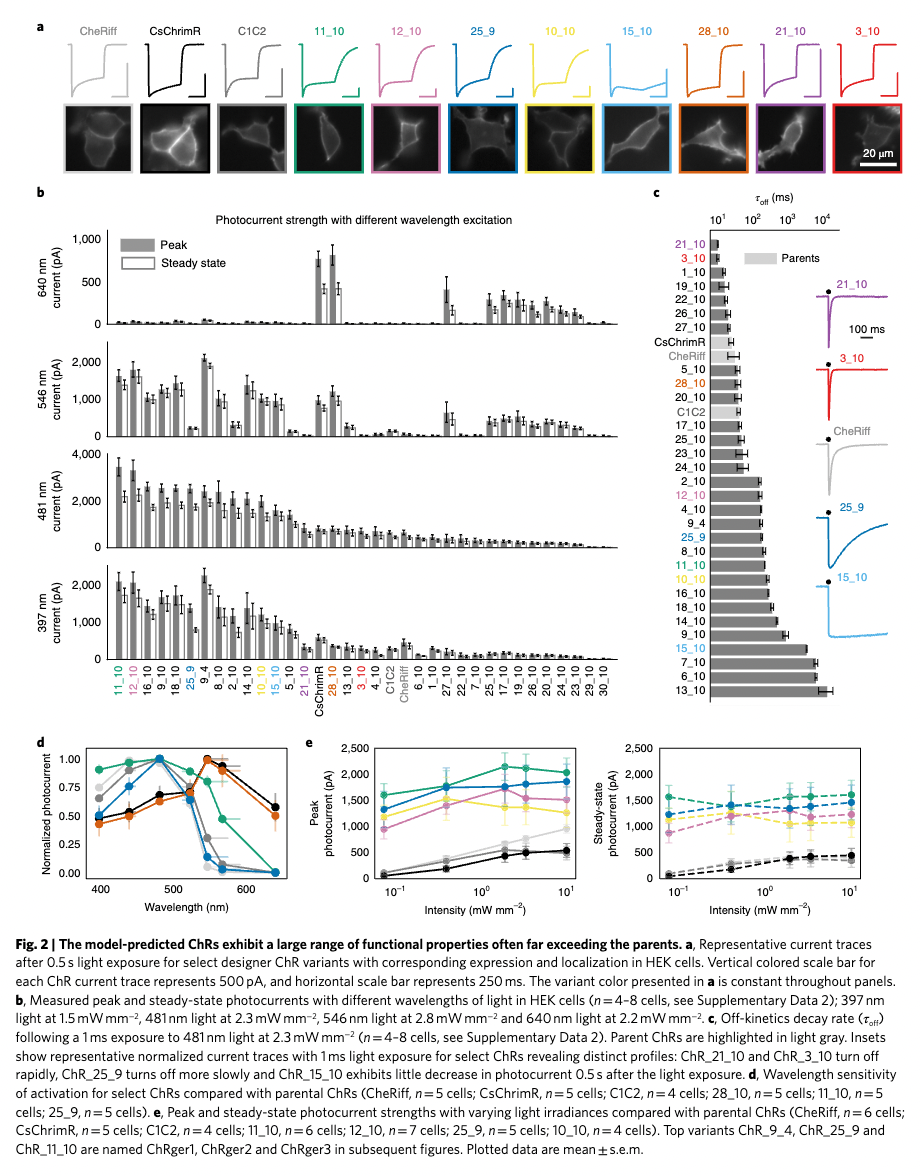

In [221]:
fig

In [222]:
message = claude.messages.create(
    model="claude-3-5-sonnet-20240620",
    max_tokens=1000,
    temperature=0,
    # system="You are an expert scientist who is asked questions about figures from scientific papers. Do your best to answer them accurately.",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt.format(llm=plotreader._MM_LLM)
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": image_to_base64(fig)
                    }
                }
            ]
        }
    ]
)


In [223]:
sample['question']

'Wld S protection of the cerebral cortex and hippocampus following traumatic brain injury occurs from which of the following?'

In [224]:
print("CLAUDE'S ANSWER:")
for block in message.content:
    try:
        pprint(block.text)
    except:
        pass

# print("IDEAL ANSWER:")
# print(sample['ideal'])

CLAUDE'S ANSWER:
('{\n'
 '  "opsins": [\n'
 '    {\n'
 '      "aliases": ["ChRiff"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["CsChrimR"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["C1C2"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["11_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["12_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["25_9"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["10_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["15_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["28_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["21_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["3_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["1_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["19_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["22_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["26_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["27_10"]\n'
 '    },\n'
 '    {\n'
 '      "aliases": ["5_10"]\n'
 '    },\n'
 '    {\n'
 '      "ali

In [225]:
len(message.content)

1

In [226]:
opsin_set = output_parser.parse(message.content[0].text)

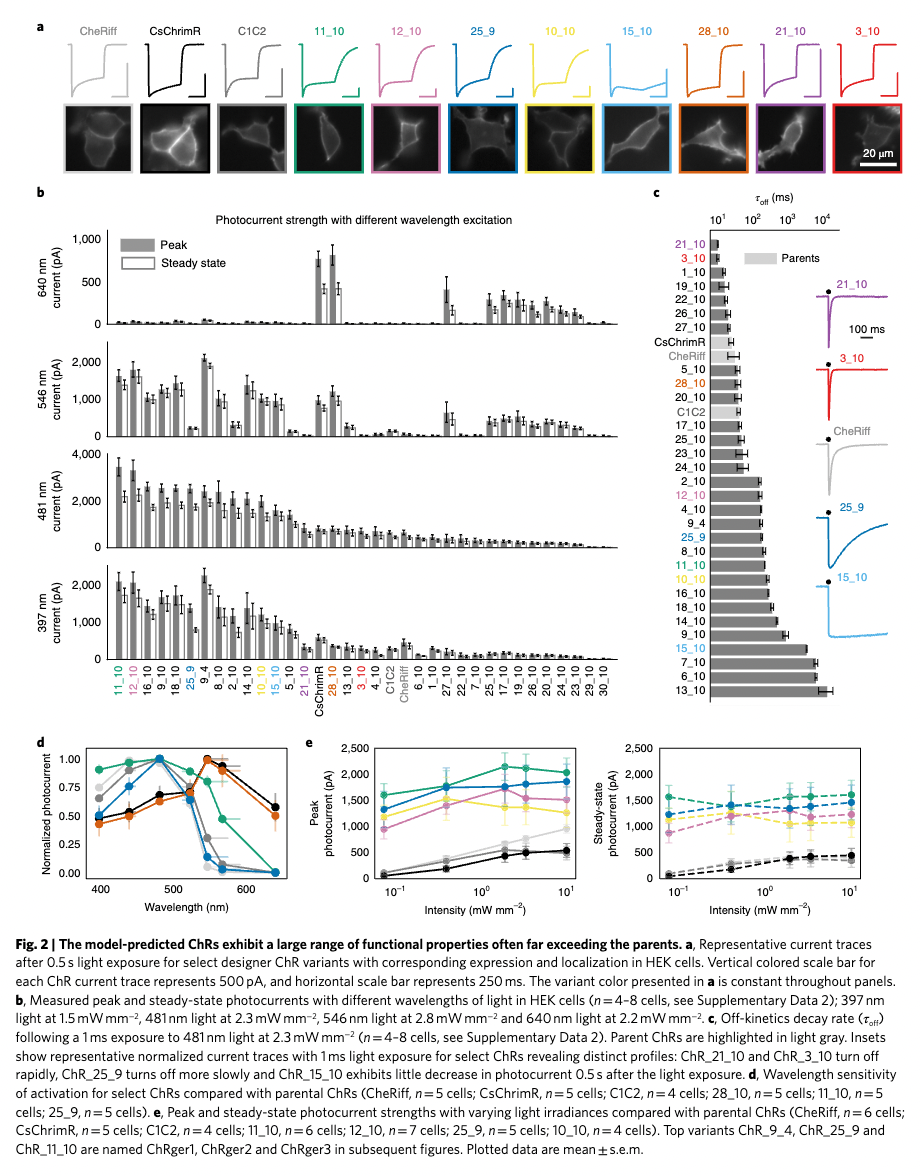

In [231]:
fig

In [232]:
print(message_txt_no_options)

for opsin in opsin_set.opsins:
    print(f"{type(opsin)}: {opsin}")

List each opsin variant tested in this figure and denote any aliases used. Return your answer as structured data.
<class '__main__.Opsin'>: aliases=['ChRiff']
<class '__main__.Opsin'>: aliases=['CsChrimR']
<class '__main__.Opsin'>: aliases=['C1C2']
<class '__main__.Opsin'>: aliases=['11_10']
<class '__main__.Opsin'>: aliases=['12_10']
<class '__main__.Opsin'>: aliases=['25_9']
<class '__main__.Opsin'>: aliases=['10_10']
<class '__main__.Opsin'>: aliases=['15_10']
<class '__main__.Opsin'>: aliases=['28_10']
<class '__main__.Opsin'>: aliases=['21_10']
<class '__main__.Opsin'>: aliases=['3_10']
<class '__main__.Opsin'>: aliases=['1_10']
<class '__main__.Opsin'>: aliases=['19_10']
<class '__main__.Opsin'>: aliases=['22_10']
<class '__main__.Opsin'>: aliases=['26_10']
<class '__main__.Opsin'>: aliases=['27_10']
<class '__main__.Opsin'>: aliases=['5_10']
<class '__main__.Opsin'>: aliases=['C1C2']
<class '__main__.Opsin'>: aliases=['17_10']
<class '__main__.Opsin'>: aliases=['23_10']
<class '